In [1]:
!pip install pycaret

ข้อมูลตัวอย่าง:
         date       pm25  temperature   humidity  wind_speed      rain  year  \
13 2023-03-25  12.601593    38.193706  61.794085   12.083493  1.075238  2023   
14 2023-03-26  18.252465    36.855986  72.508832   10.295900  0.287240  2023   
15 2023-03-27  53.131374    30.420344  59.131426   12.092424  0.034536  2023   
16 2023-03-28  39.615066    35.401543  43.784152   13.265764  2.582249  2023   
17 2023-03-29  79.427420    38.387208  58.793763    5.672749  1.765598  2023   

    month  day  dayofweek  is_weekend  pm25_lag_1  pm25_lag_2  pm25_lag_3  \
13      3   25          5           1   77.258868   56.028107   56.097469   
14      3   26          6           1   12.601593   77.258868   56.028107   
15      3   27          0           0   18.252465   12.601593   77.258868   
16      3   28          1           0   53.131374   18.252465   12.601593   
17      3   29          2           0   39.615066   53.131374   18.252465   

    pm25_lag_7  pm25_rolling_mean_3  pm2

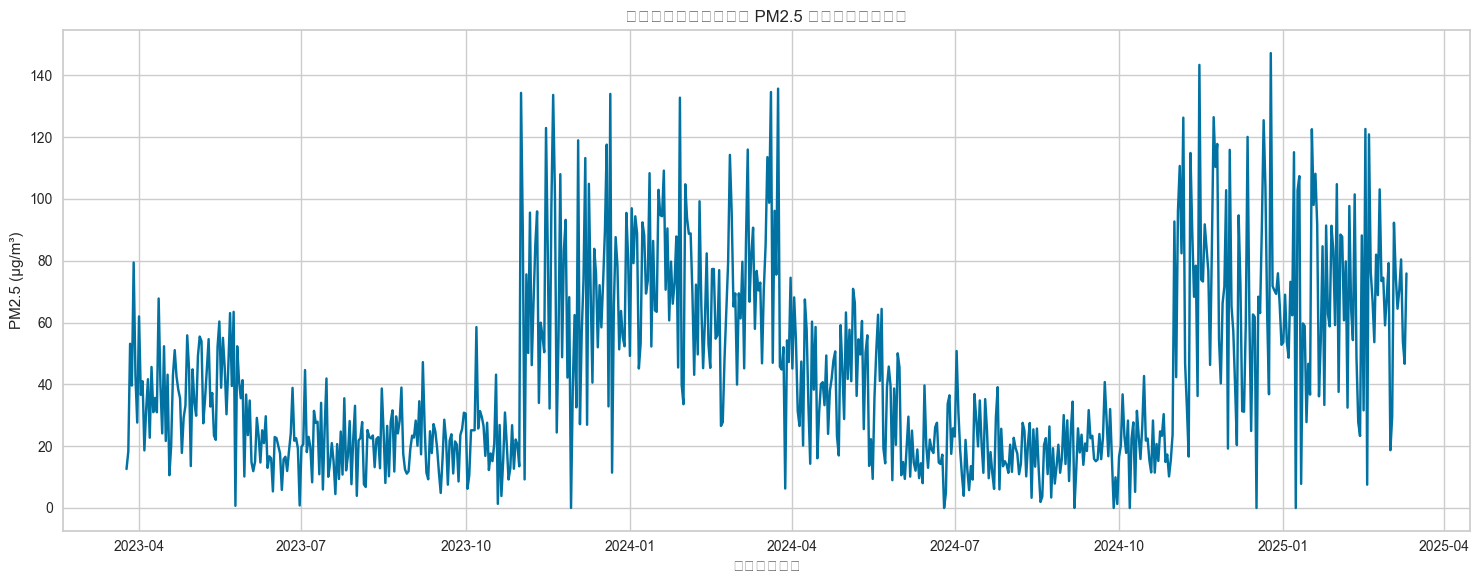

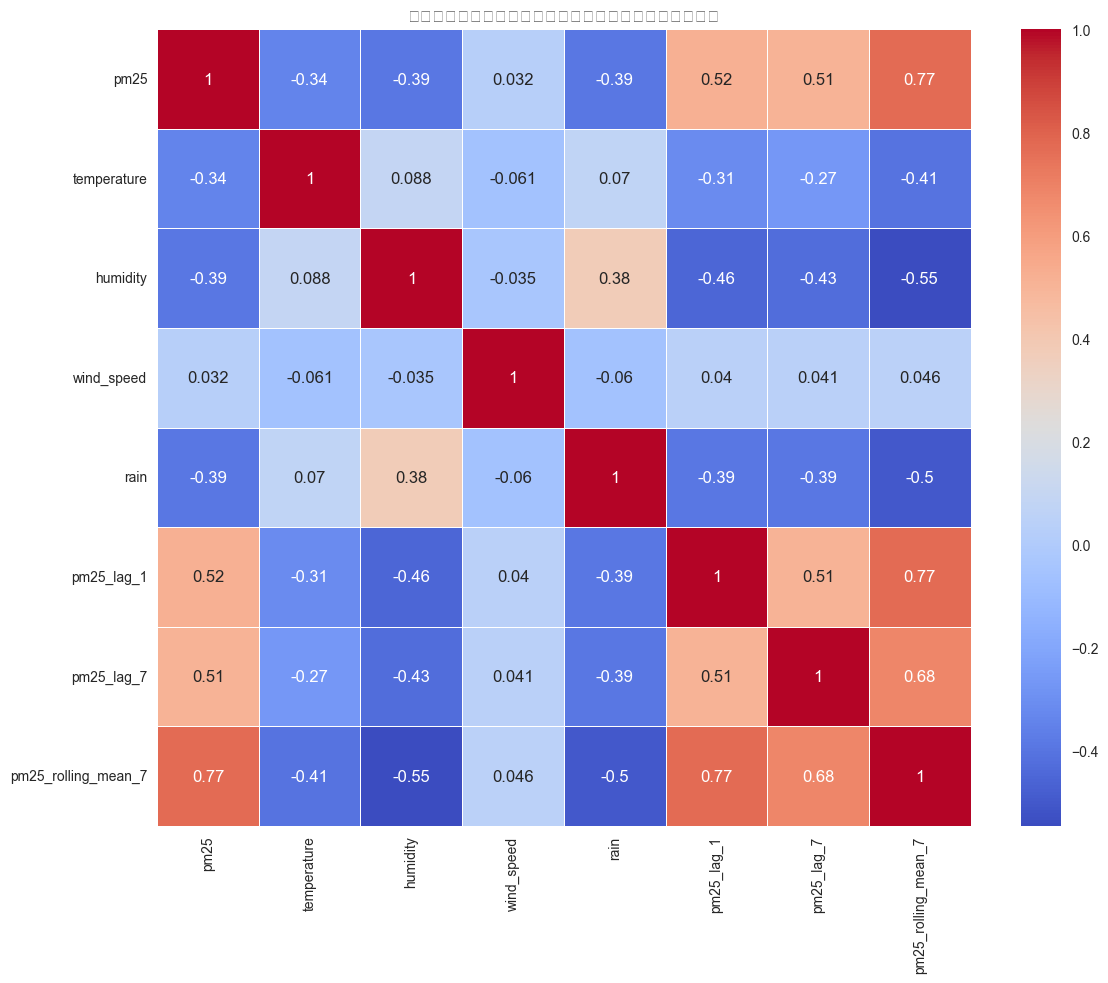

In [7]:
import pandas as pd
import numpy as np
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# สร้างข้อมูลจำลองสำหรับการทดลอง
# ในกรณีจริง คุณควรใช้ข้อมูลจริงจากเซ็นเซอร์หรือฐานข้อมูลที่มีอยู่
def create_sample_data(days=365*2):
    np.random.seed(42)
    
    # สร้างวันที่
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=days)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # สร้างค่า PM2.5 พื้นฐานที่มีความแปรปรวนตามฤดูกาล
    # สมมติให้เดือนที่มีค่า PM2.5 สูงคือเดือน 12-3 (ฤดูหนาวและฤดูแล้ง)
    pm25_base = np.zeros(len(date_range))
    for i, date in enumerate(date_range):
        month = date.month
        # ฤดูหนาวและฤดูแล้ง (พ.ย.-มี.ค.) มีค่า PM2.5 สูง
        if month >= 11 or month <= 3:
            pm25_base[i] = np.random.normal(70, 30)
        # ฤดูฝน (มิ.ย.-ต.ค.) มีค่า PM2.5 ต่ำ
        elif month >= 6 and month <= 10:
            pm25_base[i] = np.random.normal(20, 10)
        # ช่วงเปลี่ยนฤดู (เม.ย.-พ.ค.) มีค่ากลาง ๆ
        else:
            pm25_base[i] = np.random.normal(40, 15)
    
    # ทำให้แน่ใจว่าไม่มีค่าติดลบ
    pm25_base = np.maximum(pm25_base, 0)
    
    # สร้างตัวแปรอื่น ๆ ที่อาจมีผลต่อ PM2.5
    temperature = []
    humidity = []
    wind_speed = []
    rain = []
    
    for date in date_range:
        month = date.month
        
        # อุณหภูมิมีความสัมพันธ์กับฤดูกาล
        if month >= 11 or month <= 2:  # ฤดูหนาว
            temp = np.random.normal(22, 5)
        elif month >= 3 and month <= 5:  # ฤดูร้อน
            temp = np.random.normal(35, 3)
        else:  # ฤดูฝน
            temp = np.random.normal(30, 4)
        temperature.append(temp)
        
        # ความชื้นแปรผกผันกับ PM2.5 ในบางฤดู
        if month >= 6 and month <= 10:  # ฤดูฝน
            hum = np.random.normal(80, 10)
        else:
            hum = np.random.normal(60, 15)
        humidity.append(min(max(hum, 0), 100))  # ความชื้นอยู่ในช่วง 0-100%
        
        # ความเร็วลมมีผลในการพัดพาฝุ่น
        ws = np.random.normal(8, 5)
        wind_speed.append(max(ws, 0))
        
        # ปริมาณฝนช่วยลดฝุ่น
        if month >= 6 and month <= 10:  # ฤดูฝน
            r = np.random.exponential(10)
        else:
            r = np.random.exponential(1)
        rain.append(max(r, 0))
    
    # สร้าง DataFrame
    data = pd.DataFrame({
        'date': date_range,
        'pm25': pm25_base,
        'temperature': temperature,
        'humidity': humidity,
        'wind_speed': wind_speed,
        'rain': rain
    })
    
    # เพิ่มคุณลักษณะเกี่ยวกับเวลา
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # ข้อมูลล่าช้า (Lag Features) - มีประโยชน์มากในการพยากรณ์อนุกรมเวลา
    for lag in [1, 2, 3, 7]:
        data[f'pm25_lag_{lag}'] = data['pm25'].shift(lag)
    
    # คำนวณค่าเฉลี่ยเคลื่อนที่
    for window in [3, 7, 14]:
        data[f'pm25_rolling_mean_{window}'] = data['pm25'].rolling(window=window).mean()
    
    # ลบแถวที่มีค่า NaN (เกิดจากการสร้าง lag features)
    data = data.dropna()
    
    return data

# สร้างข้อมูลจำลอง
data = create_sample_data()

# แสดงข้อมูลตัวอย่าง
print("ข้อมูลตัวอย่าง:")
print(data.head())

# สถิติพรรณนาของข้อมูล
print("\nสถิติพรรณนาของข้อมูล:")
print(data.describe())

# แสดงกราฟแนวโน้มค่า PM2.5
plt.figure(figsize=(15, 6))
plt.plot(data['date'], data['pm25'])
plt.title('แนวโน้มค่า PM2.5 ตลอดเวลา')
plt.xlabel('วันที่')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
correlation_vars = ['pm25', 'temperature', 'humidity', 'wind_speed', 'rain', 
                    'pm25_lag_1', 'pm25_lag_7', 'pm25_rolling_mean_7']
correlation_matrix = data[correlation_vars].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('ความสัมพันธ์ระหว่างตัวแปร')
plt.tight_layout()
plt.show()

In [8]:
# แบ่งข้อมูลเป็นชุดฝึกสอนและชุดทดสอบ (time-based split)
split_date = data['date'].max() - timedelta(days=30)
train_data = data[data['date'] <= split_date].copy()
test_data = data[data['date'] > split_date].copy()

print(f"\nจำนวนข้อมูลในชุดฝึกสอน: {len(train_data)}")
print(f"จำนวนข้อมูลในชุดทดสอบ: {len(test_data)}")


จำนวนข้อมูลในชุดฝึกสอน: 688
จำนวนข้อมูลในชุดทดสอบ: 30


In [9]:
train_for_pycaret = train_data.drop('date', axis=1)
test_for_pycaret = test_data.drop('date', axis=1)

regression_setup = setup(
    data=train_for_pycaret,
    target='pm25',
    train_size=0.8,
    session_id=123,
    normalize=True,
    transformation=True,
   
)

# เปรียบเทียบโมเดลต่าง ๆ
best_models = compare_models(n_select=5)

,Description,Value
0,Session id,123
1,Target,pm25
2,Target type,Regression
3,Original data shape,"(688, 17)"
4,Transformed data shape,"(688, 17)"
5,Transformed train set shape,"(550, 17)"
6,Transformed test set shape,"(138, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,7.4293,109.4558,10.4201,0.8710,0.4220,0.4061,0.0660
lightgbm,Light Gradient Boosting Machine,6.5897,115.4520,10.5045,0.8675,0.3648,0.3029,0.1140
huber,Huber Regressor,9.3212,177.1538,13.2085,0.7978,0.5354,0.5326,0.0140
rf,Random Forest Regressor,9.1745,176.7906,13.1775,0.7944,0.4567,0.4702,0.0770
ridge,Ridge Regression,9.5008,179.8441,13.2888,0.7919,0.5564,0.5788,0.0200
br,Bayesian Ridge,9.5077,179.8025,13.2875,0.7919,0.5533,0.5822,0.0130
lr,Linear Regression,9.5266,180.1650,13.2971,0.7913,0.5544,0.5901,0.4940
lasso,Lasso Regression,10.0469,212.0906,14.4279,0.7599,0.5219,0.5588,0.2360
llar,Lasso Least Angle Regression,10.0474,212.1199,14.4288,0.7599,0.5221,0.5588,0.0150
et,Extra Trees Regressor,10.2447,216.6073,14.5655,0.7476,0.4899,0.5215,0.0610


In [10]:
# สร้างโมเดลที่ดีที่สุด (tuned)
tuned_model = tune_model(best_models[0])

# ประเมินโมเดลกับข้อมูลทดสอบ
print("\nผลการประเมินโมเดลกับข้อมูลทดสอบ:")
evaluate_model(tuned_model)

# ทำนายค่า PM2.5 ในชุดทดสอบ
predictions = predict_model(tuned_model, data=test_for_pycaret)
print("\nผลการทำนายในชุดทดสอบ:")
print(predictions[['pm25', 'prediction_label']].head())

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.8494,100.5330,10.0266,0.8675,0.3311,0.2972
1,6.2103,74.1663,8.6120,0.9067,0.2133,0.1682
2,7.1809,118.1860,10.8713,0.8942,0.4831,0.1837
3,6.4446,91.4786,9.5644,0.8148,0.4012,0.2553
4,8.1813,125.8885,11.2200,0.8319,0.7436,0.5287
5,6.1960,112.9102,10.6259,0.9070,0.3659,0.5603
6,5.4551,65.9671,8.1220,0.9363,0.2475,0.2192
7,6.1359,81.0403,9.0022,0.9147,0.2176,0.1750
8,6.4598,73.3524,8.5646,0.9139,0.3804,0.4458


Fitting 10 folds for each of 10 candidates, totalling 100 fits

ผลการประเมินโมเดลกับข้อมูลทดสอบ:


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.0538,127.2715,11.2815,0.8382,0.3196,0.2735



ผลการทำนายในชุดทดสอบ:
           pm25  prediction_label
701  101.470276        103.685505
702   48.869690         61.659221
703   27.746161         48.269228
704   23.301125         26.344793
705   88.180298         77.033466


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(test_data['date'], test_data['pm25'], label='ค่าจริง', marker='o',color = 'red')
plt.plot(test_data['date'], predictions['prediction_label'], label='ค่าทำนาย', marker='x')
plt.title('เปรียบเทียบค่า PM2.5 จริงกับค่าทำนาย')
plt.xlabel('วันที่')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



,date,pm25,temperature,humidity,wind_speed,rain,year,month,day,dayofweek,is_weekend,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_lag_7,pm25_rolling_mean_3,pm25_rolling_mean_7,pm25_rolling_mean_14
701,2025-02-10,101.470277,18.218383,62.588253,14.012389,0.083585,2025,2,10,0,0,54.318309,64.452936,97.720811,87.793038,73.413841,70.132360,74.526667
702,2025-02-11,48.869689,23.585735,94.071746,5.978013,1.764064,2025,2,11,1,0,101.470277,54.318309,64.452936,60.713607,68.219425,68.440372,71.493873
703,2025-02-12,27.746161,18.466351,73.479727,10.797885,0.041119,2025,2,12,2,0,48.869689,101.470277,54.318309,79.783991,59.362042,61.006397,67.523749
704,2025-02-13,23.301125,17.932348,66.539631,0.000000,0.869038,2025,2,13,3,0,27.746161,48.869689,101.470277,32.466593,33.305658,59.697044,64.961614
705,2025-02-14,88.180299,22.933810,67.089946,14.895813,3.006446,2025,2,14,4,0,23.301125,27.746161,48.869689,97.720811,46.409195,58.334114,63.775929
706,2025-02-15,31.587119,21.583099,49.875990,5.984620,0.579561,2025,2,15,5,1,88.180299,23.301125,27.746161,64.452936,47.689514,53.638997,63.348716
707,2025-02-16,122.643825,15.676568,82.939448,8.658223,2.326911,2025,2,16,6,1,31.587119,88.180299,23.301125,54.318309,80.803748,63.399785,65.789127
708,2025-02-17,7.542118,19.052163,40.610620,5.339157,0.584432,2025,2,17,0,0,122.643825,31.587119,88.180299,101.470277,53.924354,49.981477,60.056919
709,2025-02-18,120.893691,23.629204,78.125217,13.707322,0.808978,2025,2,18,1,0,7.542118,122.643825,31.587119,48.869689,83.693211,60.270620,64.355496
710,2025-02-19,76.330524,19.203350,66.662975,13.506615,1.534356,2025,2,19,2,0,120.893691,7.542118,122.643825,27.746161,68.255444,67.211243,64.108820



ผลการพยากรณ์ค่า PM2.5 ล่วงหน้า 7 วัน:
    วันที่  ค่า PM2.5 (µg/m³)  อุณหภูมิ (°C)  ความชื้น (%)  ความเร็วลม (km/h)  ปริมาณฝน (mm)
2025-03-12          56.513553      35.093906     64.989994           5.735721       0.816558
2025-03-13          51.489125      35.245937     67.868418           5.780266       0.946016
2025-03-14          70.663153      35.233761     67.905147           6.117393       1.027101
2025-03-15          55.398792      34.781029     69.735205           6.000918       1.177782
2025-03-16          53.404154      34.483713     68.896973           6.718193       0.927409
2025-03-17          66.986760      33.276371     70.560435           6.789844       1.017605
2025-03-18          57.850598      32.814689     72.815412           6.971287       1.109828


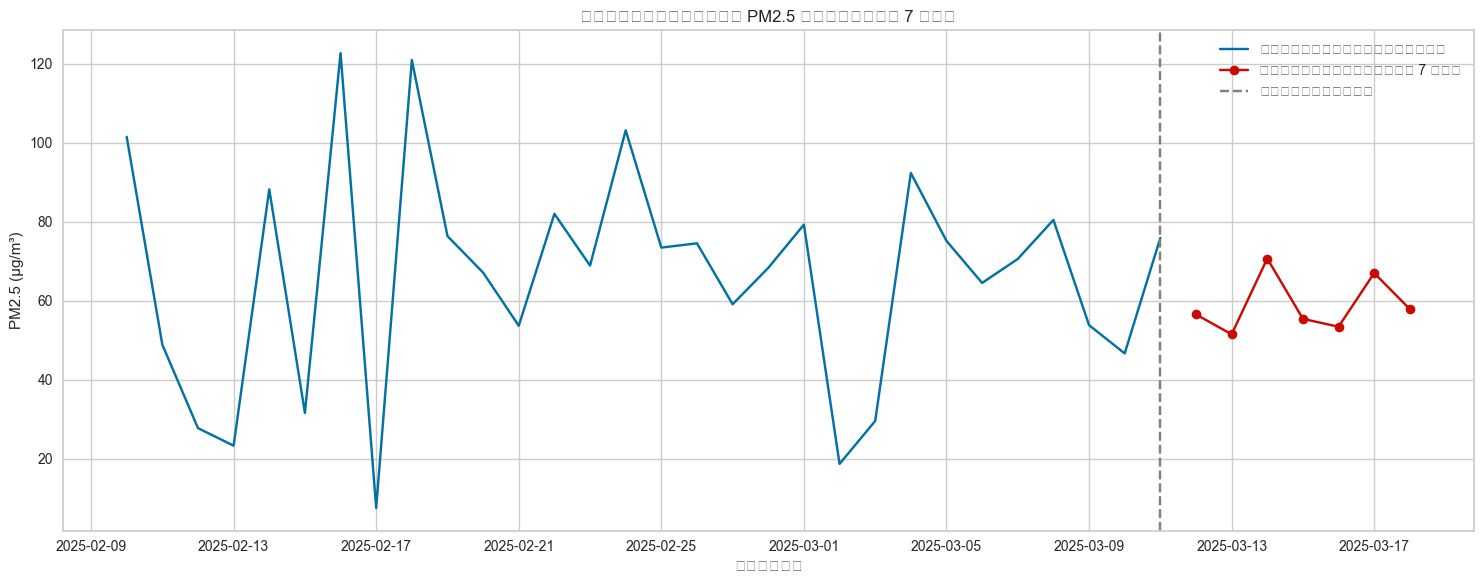

In [13]:
# สร้างข้อมูลสำหรับการพยากรณ์ในอนาคต 7 วัน
# เราต้องสร้างชุดข้อมูลใหม่โดยใช้ข้อมูลล่าสุดและค่อยๆ ทำนายไปทีละวัน
# เพราะข้อมูลวันก่อนหน้าที่ทำนายไปแล้วจะถูกใช้เป็น lag features สำหรับการทำนายวันถัดไป

# ฟังก์ชันสำหรับการพยากรณ์ล่วงหน้า 7 วัน
def forecast_next_7_days(model, last_data):
    # สร้างวันที่สำหรับการพยากรณ์
    last_date = last_data['date'].max()
    future_dates = [last_date + timedelta(days=i+1) for i in range(7)]
    
    # เตรียมข้อมูลสำหรับการพยากรณ์
    future_data = []
    current_data = last_data.copy()
    
    for future_date in future_dates:
        # สร้างแถวข้อมูลใหม่สำหรับวันที่จะพยากรณ์
        new_row = {
            'date': future_date,
            'year': future_date.year,
            'month': future_date.month,
            'day': future_date.day,
            'dayofweek': future_date.weekday(),
            'is_weekend': 1 if future_date.weekday() >= 5 else 0
        }
        
        # สมมติค่าอุตุนิยมวิทยาจากการสุ่มรอบๆ ค่าเฉลี่ยของข้อมูลล่าสุด
        # ในกรณีจริงคุณควรใช้ข้อมูลพยากรณ์อากาศที่ได้จาก API
        temp_mean = current_data['temperature'].tail(7).mean()
        humidity_mean = current_data['humidity'].tail(7).mean()
        wind_mean = current_data['wind_speed'].tail(7).mean()
        rain_mean = current_data['rain'].tail(7).mean()
        
        new_row['temperature'] = np.random.normal(temp_mean, 2)
        new_row['humidity'] = min(max(np.random.normal(humidity_mean, 5), 0), 100)
        new_row['wind_speed'] = max(np.random.normal(wind_mean, 2), 0)
        new_row['rain'] = max(np.random.exponential(rain_mean), 0)
        
        # ใช้ข้อมูลล่าสุดสำหรับ lag features
        for lag in [1, 2, 3, 7]:
            if len(current_data) >= lag:
                new_row[f'pm25_lag_{lag}'] = current_data['pm25'].iloc[-lag]
            else:
                # ถ้าข้อมูลไม่พอ ใช้ค่าเฉลี่ย
                new_row[f'pm25_lag_{lag}'] = current_data['pm25'].mean()
        
        # คำนวณค่าเฉลี่ยเคลื่อนที่
        for window in [3, 7, 14]:
            if len(current_data) >= window:
                new_row[f'pm25_rolling_mean_{window}'] = current_data['pm25'].tail(window).mean()
            else:
                new_row[f'pm25_rolling_mean_{window}'] = current_data['pm25'].mean()
        
        # สร้าง DataFrame สำหรับการทำนาย
        new_df = pd.DataFrame([new_row])
        
        # ทำนายค่า PM2.5
        new_df_no_date = new_df.drop('date', axis=1)
        prediction = predict_model(model, data=new_df_no_date)
        
        # เพิ่มค่า PM2.5 ที่ทำนายได้
        new_row['pm25'] = prediction['prediction_label'].iloc[0]
        
        # เพิ่มข้อมูลใหม่ลงในอนาคต
        future_data.append(new_row)
        
        # เพิ่มข้อมูลใหม่ลงในข้อมูลปัจจุบันเพื่อใช้ทำนายวันถัดไป
        current_data = pd.concat([current_data, pd.DataFrame([new_row])], ignore_index=True)
    
    # สร้าง DataFrame จากข้อมูลที่พยากรณ์ได้
    future_df = pd.DataFrame(future_data)
    return future_df

# ประมวลผลการพยากรณ์ล่วงหน้า 7 วัน
latest_data = data.copy()
forecast_data = forecast_next_7_days(tuned_model, latest_data)

# แสดงผลการพยากรณ์
print("\nผลการพยากรณ์ค่า PM2.5 ล่วงหน้า 7 วัน:")
forecast_display = forecast_data[['date', 'pm25', 'temperature', 'humidity', 'wind_speed', 'rain']].copy()
forecast_display['date'] = forecast_display['date'].dt.strftime('%Y-%m-%d')
forecast_display = forecast_display.rename(columns={
    'date': 'วันที่', 
    'pm25': 'ค่า PM2.5 (µg/m³)', 
    'temperature': 'อุณหภูมิ (°C)',
    'humidity': 'ความชื้น (%)', 
    'wind_speed': 'ความเร็วลม (km/h)', 
    'rain': 'ปริมาณฝน (mm)'
})
print(forecast_display.to_string(index=False))

# สร้างกราฟแสดงผลการพยากรณ์ล่วงหน้า
plt.figure(figsize=(15, 6))
# แสดงข้อมูลจริง 30 วันล่าสุด
plt.plot(data['date'].tail(30), data['pm25'].tail(30), 'b-', label='ข้อมูลจริงย้อนหลัง')
# แสดงข้อมูลที่พยากรณ์ล่วงหน้า 7 วัน
plt.plot(forecast_data['date'], forecast_data['pm25'], 'r-o', label='พยากรณ์ล่วงหน้า 7 วัน')
plt.axvline(x=data['date'].max(), color='gray', linestyle='--', label='วันปัจจุบัน')
plt.title('การพยากรณ์ค่า PM2.5 ล่วงหน้า 7 วัน')
plt.xlabel('วันที่')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def assess_air_quality(pm25_value):
    if pm25_value <= 25:
        return "ดี", "#4caf50"
    elif pm25_value <= 50:
        return "ปานกลาง", "#ffeb3b"
    elif pm25_value <= 100:
        return "เริ่มมีผลต่อสุขภาพ", "#ff9800"
    elif pm25_value <= 200:
        return "มีผลต่อสุขภาพ", "#f44336"
    elif pm25_value <= 300:
        return "มีผลต่อสุขภาพมาก", "#9c27b0"
    else:
        return "อันตราย", "#7d0000"

# เพิ่มคอลัมน์ระดับคุณภาพอากาศ
forecast_data['air_quality_level'], forecast_data['color'] = zip(*forecast_data['pm25'].apply(assess_air_quality))

# แสดงผลการพยากรณ์พร้อมระดับคุณภาพอากาศ
print("\nการพยากรณ์ค่า PM2.5 และระดับคุณภาพอากาศล่วงหน้า 7 วัน:")
forecast_quality = forecast_data[['date', 'pm25', 'air_quality_level']].copy()
forecast_quality['date'] = forecast_quality['date'].dt.strftime('%Y-%m-%d')
forecast_quality = forecast_quality.rename(columns={
    'date': 'วันที่', 
    'pm25': 'ค่า PM2.5 (µg/m³)', 
    'air_quality_level': 'ระดับคุณภาพอากาศ'
})
print(forecast_quality.to_string(index=False))

# บันทึกโมเดลเพื่อนำไปใช้ในเว็บแอปพลิเคชัน
print("\nกำลังบันทึกโมเดล...")
save_model(tuned_model, 'pm25_forecasting_model')
print("บันทึกโมเดลเรียบร้อยแล้ว ไฟล์ชื่อ: pm25_forecasting_model.pkl")

print("\nเสร็จสิ้นการทำนายค่า PM2.5 ล่วงหน้า 7 วัน")